In [117]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Sample function to understand the derivatives and get intuition about the derivatives.
This function can take a lot of x values and produce y values, this plots a parabola.
This parabola has a derivative. Instead of using symbolic approach as we did in our school days, we have to understand what derivative tells about the function.
Intuitively, derivative tells about sensitivity of the input to the overall function. i.e. a change in output due to a slight bump in the input value w.r.t to the input value. i.e. slope of the function at that point of input.


In [118]:
def f(x):
    return 3*x**2 - 4*x + 5


In [119]:
f(3.0)


20.0

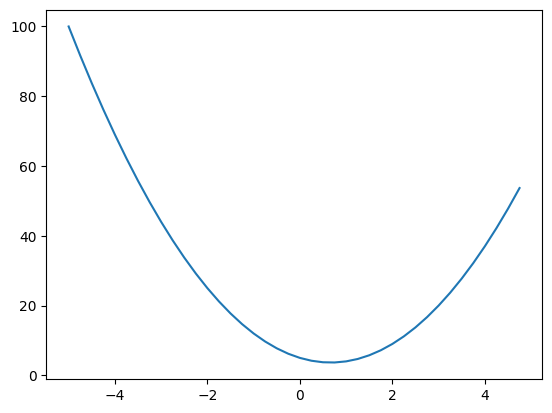

In [120]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)


In [121]:
h = 0.000001
x = 2/3
(f(x+h) - f(x)) / h


2.999378523327323e-06

In [122]:
# more complex example
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)


4.0


In [123]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
c += h
d2 = a * b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 3.999699999999999
slope -3.000000000010772
d1 4.0
d2 4.0002
slope 2.0000000000042206
d1 4.0
d2 4.0001
slope 0.9999999999976694


In [124]:
class Value:

    def __init__(self, data, _children=(), _op=(), label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    # def __sub__(self, other):
    #     other = other if isinstance(other, Value) else Value(other)
    #     out = Value(self.data - other.data, (self, other), "-")
    #     def _backward():
    #         self.grad += 1.0 * out.grad
    #         other.grad -= 1.0 * out.grad
    #     out._backward = _backward
    #     return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    # def __div__(self, other):
    #     return Value(self.data / other.data, (self, other), "/")
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int/float powers for now'
        out = Value(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e+c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L


Value(data=-8.0)

In [125]:
a = Value(2.0)
b = Value(4.0)
b -a

Value(data=2.0)

In [126]:
# scary code that can be used to visualize the Value => #TODO explore this later
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):  # sourcery skip: remove-unnecessary-cast
    dot = Digraph(format='svg', graph_attr={
                  'rankdir': 'LR'})  # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s|data:%.4f|grad:%.4f}" % (
            n.label, n.data, n.grad,), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


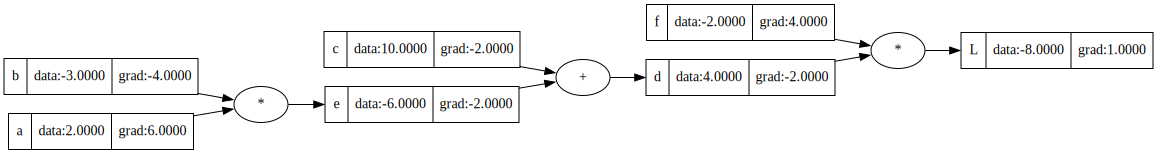

In [127]:
draw_dot(L)
L.backward()
draw_dot(L)

In [128]:
# nudging data to influence final value through gradient.
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-35.2408


Chain rule in calculus. Study this rule to understand backpropagation logic.

In [129]:
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
b.grad = -4.0
a.grad = 6.0


In [130]:
L.grad = 1.0


In [131]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f
    L.label = 'L'
    L2 = L.data
    print((L2 - L1) / h)


lol()


0.0


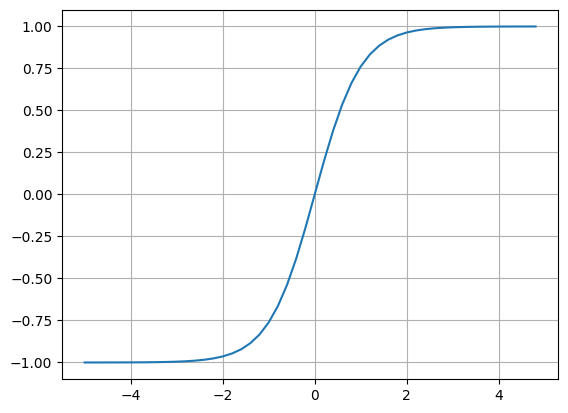

In [132]:
# activation function - tanh plotted.
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()


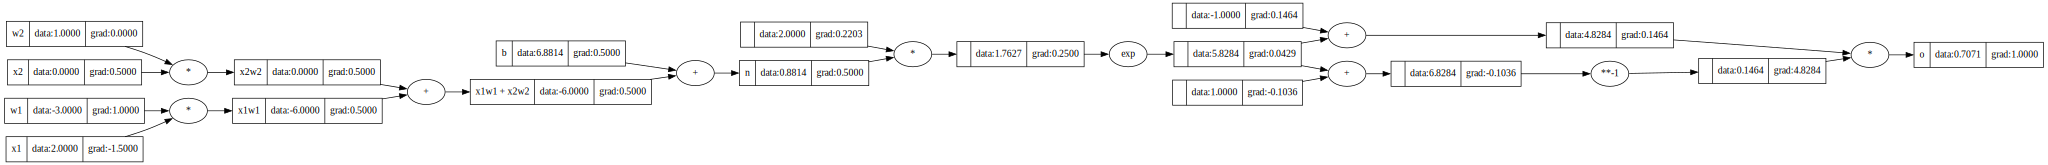

In [133]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373, label='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o'
o.backward()
draw_dot(o)

TODO: Explore about topological sort to call _backward function automatically.

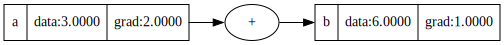

In [134]:
# a bug in the code
a = Value(3.0, label='a')
b = a + a
b.label = 'b'
b.backward()
draw_dot(b)

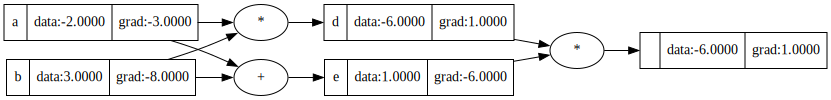

In [135]:
# in case of multivariable gradients we need to accumulate them
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b
d.label = 'd'
e = a+b
e.label = 'e'
f = d*e
f.backward()
draw_dot(f)

In [136]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.881373]).double()
b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071064519863152
---
x2 0.500000465559325
w2 0.0
x1 -1.500001396677975
w1 1.00000093111865


In [137]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [138]:
import random

In [154]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] 

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [226]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
n.parameters()

[Value(data=-0.38620666903510803),
 Value(data=0.4357468673911471),
 Value(data=-0.9530217300080923),
 Value(data=0.5004681013538748),
 Value(data=0.24378901018731458),
 Value(data=-0.7572704491668989),
 Value(data=-0.6587865297268976),
 Value(data=-0.8340796040222751),
 Value(data=-0.4128463782937093),
 Value(data=-0.9918352724190136),
 Value(data=0.7675963572764741),
 Value(data=0.44595439891849575),
 Value(data=-0.9410424786913858),
 Value(data=-0.6169622551725222),
 Value(data=0.017327975739888757),
 Value(data=-0.6485603501227992),
 Value(data=0.4313293289507363),
 Value(data=0.15159835312353542),
 Value(data=0.14048023795532028),
 Value(data=-0.37695125844313626),
 Value(data=0.9535922441930917),
 Value(data=0.49970910793420176),
 Value(data=0.4191256086813129),
 Value(data=-0.08864191145566891),
 Value(data=0.2737097283188499),
 Value(data=0.565536805928663),
 Value(data=0.7853540214326249),
 Value(data=-0.4809580858127356),
 Value(data=-0.41978006385962385),
 Value(data=0.84169

In [227]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1., 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]


In [228]:
for k in range(10000):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
    
    for p in n.parameters():
        p.grad = 0.0
        
    loss.backward()

    for p in n.parameters():
        p.data += -0.1 * p.grad
    print(k, loss.data)
ypred

0 10.64656964365706
1 6.483338750013413
2 3.1478400165734475
3 3.1299720313682196
4 2.825318053726995
5 2.8440473519882215
6 2.368013282082077
7 2.123748848844423
8 1.7582565516713766
9 1.7098270982981614
10 0.6073119961043494
11 0.042668905985369196
12 0.03849567164541854
13 0.03505941490674462
14 0.03217752815115934
15 0.029724639965655435
16 0.027611220566800206
17 0.02577135167126418
18 0.024155292350233486
19 0.022724738517982776
20 0.021449682162143997
21 0.020306264321165737
22 0.019275268530840856
23 0.018341039935191573
24 0.017490694770901007
25 0.01671353242932939
26 0.016000591638178442
27 0.015344310958722131
28 0.014738265957222739
29 0.014176963516766748
30 0.01365567926730562
31 0.013170327924744141
32 0.01271735900993876
33 0.01229367232934622
34 0.011896548979473901
35 0.011523594646540219
36 0.01117269271885362
37 0.010841965286656987
38 0.010529740524347785
39 0.01023452526960867
40 0.009954981859156092
41 0.009689908470339657
42 0.00943822236541009
43 0.00919894555

[Value(data=0.9976235978951455),
 Value(data=-0.997587141484656),
 Value(data=-0.9965217833853732),
 Value(data=0.9971216972953888)]